# MSIN0097 PREDICTIVE ANALYTICS  INDIVIDUAL ASSIGNMENT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Strokes no longer just happen to older people. According to a study by the American Heart Assocication, strokes among young people have increased more than 40% over the last few decades (Sullivan, 2021). More suprisingly, although strokes occur more often in men, women within the age of 25 to 44 are more likely to have a stroke. The aim of this project is to create a supervised machine learning model to predict whether a patient is likely to get a stroke based on several health attributes such as age, prescence of heart disesase, smoking status and bmi. The dataset is obtained from Kaggle and contains 5110 observations across 12 variables. As the project is a classification task, 4 different classification models would be trailed and shortlisted to predict the occurence of stroke. 

In [2]:
# load dataset
df = pd.read_csv(r'/Users/brennanyap/Desktop/UCL Notes/Predictive Analytics/Individual Assignment/healthcare-dataset-stroke-data.csv')

# show dataset
df.head()
print('Number of observations:', len(df))

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Number of observations: 5110


To ensure comparatively with other binary variables, preliminary data cleaning is done at this stage where values in ever_married is changed to 1, indicating married and 0, indicating not married. 

In [3]:
# simple data cleaning
df["ever_married"] = np.where(df["ever_married"] == "Yes", 1, 0)

## Understanding Data

The goal in this section is get a better understanding of the data structure of different attributes. We start by observing the proportion of unique values within each categorical variable. 

In [4]:
# exploring number of counts of categorical variables
df['gender'].value_counts()

df['hypertension'].value_counts()

df['heart_disease'].value_counts()

df['ever_married'].value_counts()

df['work_type'].value_counts()

df['Residence_type'].value_counts()

df['smoking_status'].value_counts()

df['stroke'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

0    4612
1     498
Name: hypertension, dtype: int64

0    4834
1     276
Name: heart_disease, dtype: int64

1    3353
0    1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

0    4861
1     249
Name: stroke, dtype: int64

Some interesting insights can be inferred from the results above. First, there is a slightly larger proportion of female patients compared to male patients. It was mentioned previously that men are more likely to suffer from a stroke and this could have an effect on the number of strokes within the dataset. Second, the proportion of patients that have illnesses (heart disease and hypertension) are relatively small. The percentage of patients that suffer from stroke also sits at roughtly 5% of the entire population. As these attributes are generally more correlated with getting a stroke, their relationship would be further inspected within the data visualisation section.   

In [5]:
# summary of dataset
df.describe()

,id,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,0.656164,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,0.475034,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,1.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,1.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000


The table above provides a summary of numerical attributes, indicating the count, mean, standard deviation and distribution. It is important to note that 25% of all patients are aged 61 and above. Since 70% of all strokes occur at ages above 65 years old (Kelly-Hayes, 2011), this could be a reason for the low proportion of stroke patients. Average glucose level is another important attribute that needs to be discussed. According to the Centre for Disease Control and Prevention, glucose levels below 140 mg is normal, 140-199 mg means prediabetes and levels at 200 mg and above mean diabetes. Patients in this dataset generally have healthy gluclose levels, with 75% within normal levels. The mean for body mass index is 28.9 which falls within the overweight category. 25% of patients have BMI above 33.1 and are considered obese.

To obtain a greater understanding about the distribution for attributes mentioned above, histograms are plotted below. 

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'avg_glucose_level'}>],
       [<AxesSubplot:title={'center':'bmi'}>, <AxesSubplot:>]],
      dtype=object)

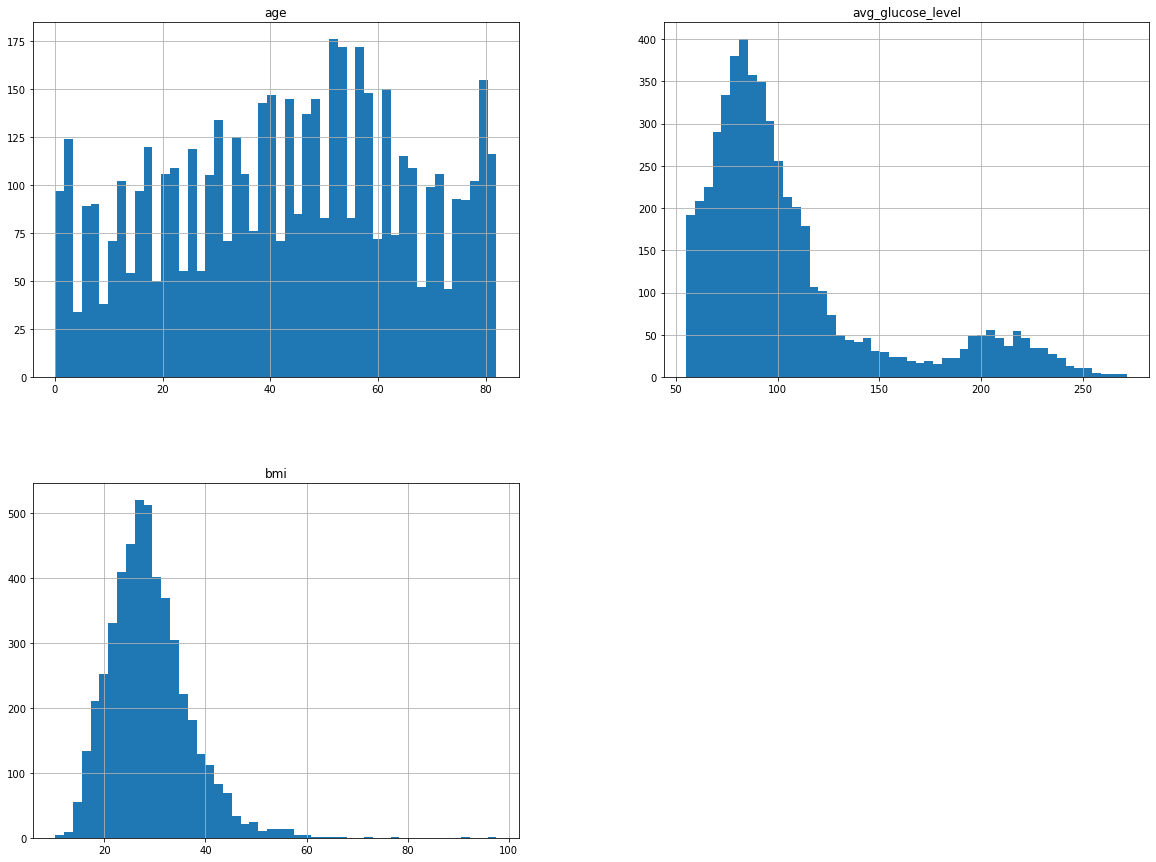

In [6]:
# historgram of numerical variables
df_histogram = df[['age', 'avg_glucose_level', "bmi"]]
df_histogram.hist(bins=50, figsize=(20,15))
plt.show()

At this stage, the dataset is split into its respective train set and test set to prevent overgeneralisation when fitting models. Furthemore, statisfied random sampling based on stroke occurence is carried out since only 5% of patients suffer from stroke, The reason for this type of split is to ensure that both train and test sets have sufficient data on stroke patients to carry out model predictions. 

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# creating test and training set using Stratisfied Random Sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=23)
for train_index, test_index in split.split(df, df["stroke"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]
    
# show observations
print("Number of observations in training set", len(train_set))
print("Number of observations in test set", len(test_set))
    

Number of observations in training set 4088
Number of observations in test set 1022


## Data Visualisation

After splitting the dataset, the training set will be explored through visualisation in order to discover patterns, relationships and correlations between attributes. We start by observing a simple relationship between age and stroke occurrence. 

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0, 0.5, 'No. of people')

Text(0.5, 0, 'Age range')

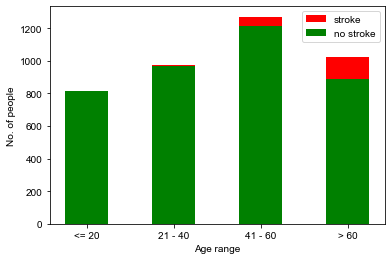

In [8]:
# observe how age affects getting a stroke 

stroke_age1 = len(train_set[(train_set['age'] <= 20) & (train_set['stroke'] == 1)])
stroke_age2 = len(train_set[(train_set['age'].between(21,40)) & (train_set['stroke'] == 1)])
stroke_age3 = len(train_set[(train_set['age'].between(41,60)) & (train_set['stroke'] == 1)])
stroke_age4 = len(train_set[(train_set['age'] > 60) & (train_set['stroke'] == 1)])

nostroke_age1 = len(train_set[(train_set['age'] <= 20) & (train_set['stroke'] == 0)])
nostroke_age2 = len(train_set[(train_set['age'].between(21,40)) & (train_set['stroke'] == 0)])
nostroke_age3 = len(train_set[(train_set['age'].between(41,60)) & (train_set['stroke'] == 0)])
nostroke_age4 = len(train_set[(train_set['age'] > 60) & (train_set['stroke'] == 0)])                            

age_range = ['<= 20', '21 - 40', '41 - 60', '> 60']
stroke = [stroke_age1, stroke_age2, stroke_age3, stroke_age4]
no_stroke = [nostroke_age1, nostroke_age2, nostroke_age3, nostroke_age4]

plt.bar(age_range, stroke, width=0.5, label='stroke', color='r', bottom= no_stroke)
plt.bar(age_range, no_stroke, width=0.5, label='no stroke', color='g')
plt.ylabel("No. of people")
plt.xlabel("Age range")
plt.legend(loc="upper right")

sns.set(rc = {'figure.figsize':(15,8)})

From the bar chart above, it is evident that patients aged 40 and below generally do not suffer from strokes except for a few outliers. As expected, the proportion of patients having a stroke increases as we move to older age bins. 

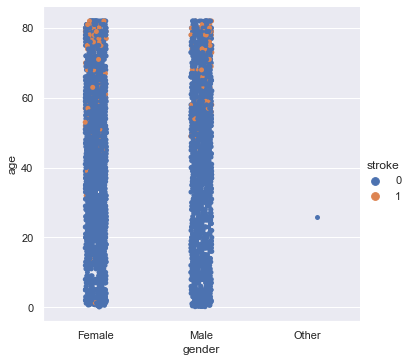

In [9]:
# relationship between gender, age and stroke
sns.catplot(x = "gender", y = "age", hue = 'stroke', data = train_set)

Similarly, from the category scatter plot above, strokes are more likely to occur to patients aged 50 and above. With regards to whether gender has a part to play in this relationship, it can be seen that women have a higher concentration stroke patients around 80 years old compared to men. Strokes also occur earlier to women in their lifetime compared to men which is testament to the findings mentioned previously. 

<AxesSubplot:>

([<matplotlib.patches.Wedge at 0x7fea2e41e310>,
 [Text(0.9937476259374091, 0.47166265057110857, 'stroke'),
  Text(-0.9937475817771603, -0.471662743612474, 'no stroke')],
 [Text(0.5420441596022231, 0.2572705366751501, '14.1%'),
  Text(-0.5420441355148147, -0.25727058742498576, '85.9%')])

Text(0.5, 1.0, '% of people with hypertension who suffer from stroke')

<AxesSubplot:>

([<matplotlib.patches.Wedge at 0x7fea2e1765e0>,
 [Text(1.0918621399595896, 0.13355548406136727, 'stroke'),
  Text(-1.0918621446487264, -0.13355544572605013, 'no stroke')],
 [Text(0.5955611672506851, 0.07284844585165487, '3.9%'),
  Text(-0.5955611698083961, -0.07284842494148189, '96.1%')])

Text(0.5, 1.0, '% of people without hypertension who suffer from stroke')

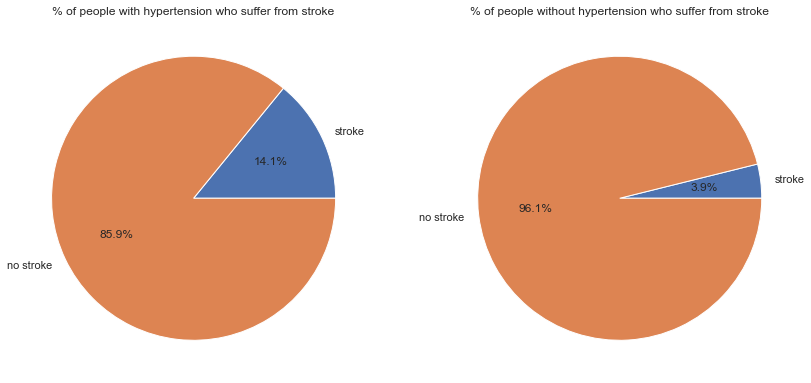

In [10]:
# explore hypertension and getting a stroke

hyper_stroke1 = len(train_set[(train_set['hypertension'] == 1) & (train_set['stroke'] == 1)])
hyper_stroke0 = len(train_set[(train_set['hypertension'] == 1) & (train_set['stroke'] == 0)])
nohyper_stroke1 = len(train_set[(train_set['hypertension'] == 0) & (train_set['stroke'] == 1)])
nohyper_stroke0 = len(train_set[(train_set['hypertension'] == 0) & (train_set['stroke'] == 0)])

labels = ['stroke', 'no stroke']
data1 = [hyper_stroke1, hyper_stroke0]
data2 = [nohyper_stroke1, nohyper_stroke0]

plt.subplot(1,2,1)
plt.pie(data1, labels = labels, autopct='%1.1f%%')
plt.title('% of people with hypertension who suffer from stroke')

plt.subplot(1,2,2)
plt.pie(data2, labels = labels, autopct='%1.1f%%')
plt.title('% of people without hypertension who suffer from stroke')

fig = plt.gcf()
fig.set_size_inches(14,14)
plt.show()

People who suffer from hypertension are more likely to get a stroke. High blood pressure is one of the most prevalent risk factors for strokes (Wajngarten & Silva, 2019) and the pie chart above proves this.

<AxesSubplot:>

([<matplotlib.patches.Wedge at 0x7fea2e8e9e50>,
 [Text(0.9620375522924628, 0.5333701791243368, 'stroke'),
  Text(-0.9620375772613218, -0.5333701340881082, 'no stroke')],
 [Text(0.5247477557958887, 0.2909291886132746, '16.1%'),
  Text(-0.5247477694152664, -0.29092916404805896, '83.9%')])

Text(0.5, 1.0, '% of people with heart disease who suffer from stroke')

<AxesSubplot:>

([<matplotlib.patches.Wedge at 0x7fea2e93c100>,
 [Text(1.0901827082017612, 0.14663445276562387, 'stroke'),
  Text(-1.09018270305342, -0.1466344910419753, 'no stroke')],
 [Text(0.5946451135645969, 0.07998242878124937, '4.3%'),
  Text(-0.5946451107564108, -0.07998244965925924, '95.7%')])

Text(0.5, 1.0, '% of people without heart disease who suffer from stroke')

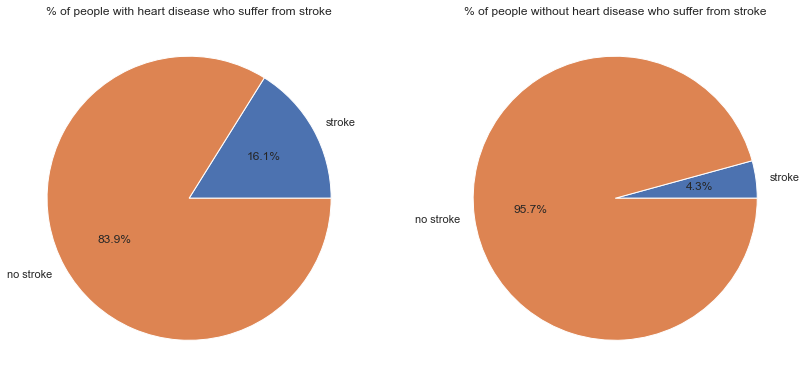

In [11]:
# explore heart disease and getting a stroke

heart_stroke1 = len(train_set[(train_set['heart_disease'] == 1) & (train_set['stroke'] == 1)])
heart_stroke0 = len(train_set[(train_set['heart_disease'] == 1) & (train_set['stroke'] == 0)])
noheart_stroke1 = len(train_set[(train_set['heart_disease'] == 0) & (train_set['stroke'] == 1)])
noheart_stroke0 = len(train_set[(train_set['heart_disease'] == 0) & (train_set['stroke'] == 0)])

labels = ['stroke', 'no stroke']
data1 = [heart_stroke1, heart_stroke0]
data2 = [noheart_stroke1, noheart_stroke0]

plt.subplot(1,2,1)
plt.pie(data1, labels = labels, autopct='%1.1f%%')
plt.title('% of people with heart disease who suffer from stroke')

plt.subplot(1,2,2)
plt.pie(data2, labels = labels, autopct='%1.1f%%')
plt.title('% of people without heart disease who suffer from stroke')

fig = plt.gcf()
fig.set_size_inches(14,14)
plt.show()

Likewise, people with heart diseases are more prone to getting a stroke, at roughly 16.1% chance. 

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

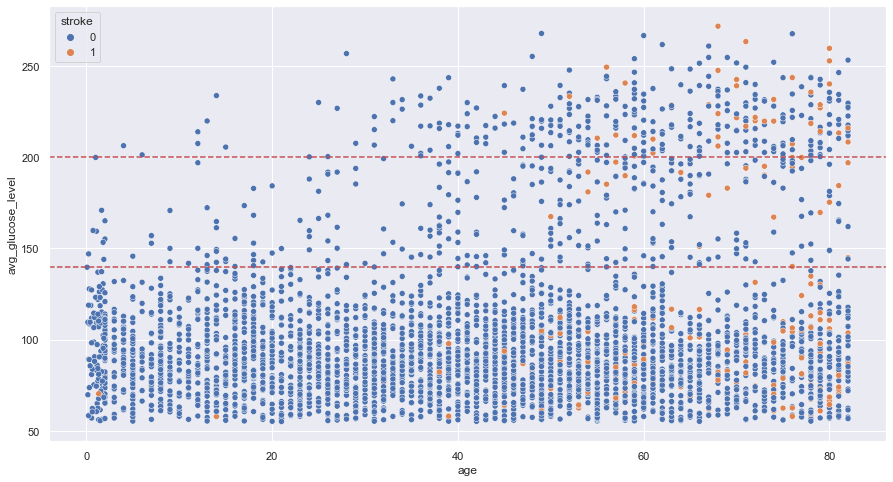

In [12]:
# scatter plot of average glucose level and age

sns.scatterplot(x = 'age', y = 'avg_glucose_level', data = train_set, hue = 'stroke')
plt.axhline(y= 140, color='r', linestyle='--')
plt.axhline(y= 200, color='r', linestyle='--')

Suprisingly, average glucose levels have an insignificant impact on stroke occurence. The scatter plot above show that patients who have normal glucose levels (below 140mg) are equally as prone to getting a stroke as diabetic patients (above 200mg). The red dotted line shows the seperation from normal, prediabetes and diabetes. 

<AxesSubplot:xlabel='age', ylabel='bmi'>

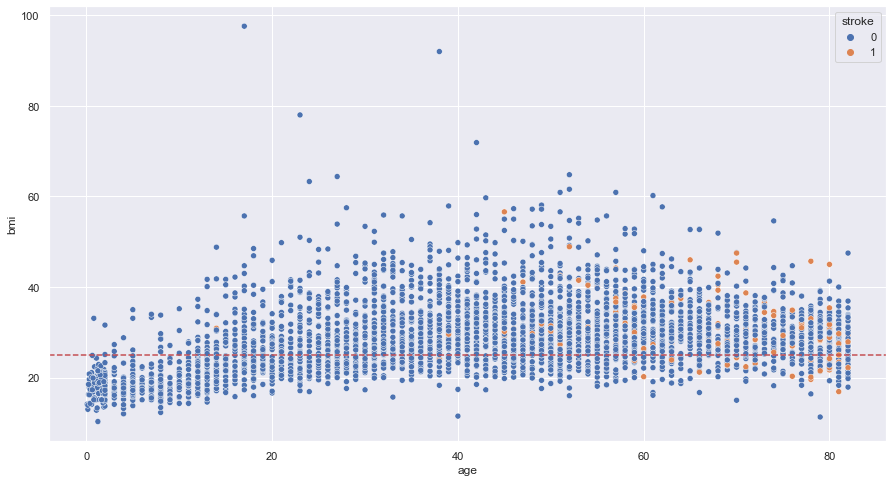

In [13]:
# scatter plot of bmi and age 

sns.scatterplot(x = 'age', y = 'bmi', data = train_set, hue = 'stroke')
plt.axhline(y= 24.9, color='r', linestyle='--')

On first notice the plot shows that strokes are more likely to occur to patients in overweight and obese BMI ranges (above 24.9, indicated by red line). However, this could be due to a larger portion of samples in this category and should not be indicative of a relationship. 

In [14]:
# correlation of each attribute with stroke
corr_matrix = train_set.corr()
corr_matrix['stroke'].sort_values(ascending=False)

stroke               1.000000
age                  0.238630
hypertension         0.140787
heart_disease        0.121913
avg_glucose_level    0.120919
ever_married         0.105071
bmi                  0.038688
id                   0.014043
Name: stroke, dtype: float64

By forming a correlation table, we can get a sense of how each attribute is correlated to stroke through a numerical value. As expected, age has the highest correlation followed by the mentioned illnesses. 

## Prepare data for Machine Learning algorithms

In this section, 3 steps are taken to systematically prepare the training set for machine learning algorithms.

##### Data Cleaning

The first step is data cleaning. We start by seperating predictors, labels and removing any unwanted attributes such as id. 

In [15]:
# split into predictors and labels
x_train = train_set.drop(["stroke","id"], axis = 1)
y_train = train_set["stroke"].copy()

Next, we explore the number of missing values in the training set by attribute.

In [16]:
# explore missing values in train set
train_set.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  159
smoking_status         0
stroke                 0
dtype: int64

It is noticed that all 159 missing samples belong in bmi. Instead of removing these samples, they would be replaced by the median bmi. The median value is favoured over mean because of the presence of outliers within the BMI attribute. Scikit-Learn's SimpleImputer will be used to perform this task

In [17]:
# fill missing values in BMI with median value

# import imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [18]:
# select numerical variables
x_train_num = x_train[["age", "hypertension", "heart_disease", "ever_married", "avg_glucose_level", "bmi"]]

# fit imputer
imputer.fit(x_train_num)

SimpleImputer(strategy='median')

In [19]:
# check median levels 
imputer.statistics_
x_train_num.median().values

array([45.  ,  0.  ,  0.  ,  1.  , 91.85, 28.  ])

array([45.  ,  0.  ,  0.  ,  1.  , 91.85, 28.  ])

In [20]:
# transform numerical attributes
imputer.transform(x_train_num)

array([[ 44.  ,   0.  ,   0.  ,   1.  ,  85.77,  32.1 ],
       [ 71.  ,   0.  ,   1.  ,   1.  , 187.88,  29.2 ],
       [ 10.  ,   0.  ,   0.  ,   0.  , 109.3 ,  20.1 ],
       ...,
       [ 65.  ,   0.  ,   0.  ,   1.  ,  74.01,  28.7 ],
       [ 11.  ,   0.  ,   0.  ,   0.  ,  90.69,  18.6 ],
       [ 71.  ,   0.  ,   0.  ,   1.  , 193.94,  22.4 ]])

In [21]:
# look at shape
imputer.transform(x_train_num).shape

(4088, 6)

##### Handling Categorical Variables

The next step is to handle categorical variables. As most Machine Learning algorithms work better in numbers, categorical attributes have to be converted into numbers. To perform this, one-hot encoding which converts each categorical attribute into binary variable columns is used.

In [22]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [23]:
# select categorical variables
x_train_cat = x_train[["gender", "work_type", "Residence_type", "smoking_status"]]

# fit encoder
cat_encoder.fit(x_train_cat)

OneHotEncoder()

In [24]:
# transform categorical attributes
cat_encoder.transform(x_train_cat)

<4088x14 sparse matrix of type '<class 'numpy.float64'>'
	with 16352 stored elements in Compressed Sparse Row format>

In [25]:
# look at array shape
cat_encoder.transform(x_train_cat).toarray().shape

(4088, 14)

##### Feature Scaling

The last step is Feature Scaling. Due to the imbalance of scales among attributes such as average glucose levels and BMI, Standardization will be used to transform numerical attributes into the same scale. Similarly, Standardization is used over Min-max scaling because of the presence of outliers. 

In [26]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [27]:
# fit scaler
scaler.fit(x_train_num)

StandardScaler()

In [28]:
# transform numerical variables
scaler.transform(x_train_num)

array([[ 0.03393281, -0.32796178, -0.2332885 ,  0.71894584, -0.44789701,
         0.41159491],
       [ 1.23501794, -0.32796178,  4.28653795,  0.71894584,  1.79900995,
         0.04246249],
       [-1.47854476, -0.32796178, -0.2332885 , -1.39092536,  0.06987521,
        -1.11584958],
       ...,
       [ 0.96811013, -0.32796178, -0.2332885 ,  0.71894584, -0.70667309,
        -0.02118103],
       [-1.43406013, -0.32796178, -0.2332885 , -1.39092536, -0.33963354,
        -1.30678014],
       [ 1.23501794, -0.32796178, -0.2332885 ,  0.71894584,  1.93235885,
        -0.82308939]])

##### Transformation Pipelines

Finally, a transformation pipeline that combines sequences of steps from above is used on the training set. Our training set is now prepared for machine learning models. 

In [29]:
# construct pipeline for numerical attributes
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

x_num_tr = num_pipeline.fit_transform(x_train_num)

In [30]:
# construct collumn transformer

from sklearn.compose import ColumnTransformer

num_attribs = list(x_train_num)
cat_attribs = list(x_train_cat)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

x_train_prepared = full_pipeline.fit_transform(x_train)

## Exploring different models

In order to predict the occurence of stroke, 4 classification models will be used: Stochastic Gradient Descent, Random Forest, Linear and Nonlinear Support Vector Machine. 

##### Stochastic Gradient Descent Classifier

The Stochastic Gradient Descent Classifier is classification model that tweaks parameters to minimize a cost function. It does so by choosing random instances in the training set and measuring the gradient of the error function until it reaches a global minimum.

In [31]:
# Stochastic Gradient Descent classifier
sgd_clf = SGDClassifier(random_state = 21)
sgd_clf.fit(x_train_prepared, y_train)

# predict
sgd_pred =  cross_val_predict(sgd_clf, x_train_prepared, y_train, cv=3)

SGDClassifier(random_state=21)

For all models, the Cross-Validation and F1 score is used for evaluation and comparison. Cross-Validation splits the training set into 3 folds and evaluates the model 3 times, each based on a different fold. Scoring is based on accuracy which measures the ratio of correct predictions. F1 score measures the harmonic mean of 2 metrics; precision and recall. Precision measures the number of correct positive predictions made out of all positive predictions whereas Recall measures the proportion of postive results that are correctly predicted. As both metrics are equally important, they are combined into a single metric for easier comparison. 

In [32]:
# evaluate using Cross-Validation
cross_val_score(sgd_clf, x_train_prepared, y_train, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_train, sgd_pred).round(4)

array([0.9515774 , 0.95084373, 0.95154185])

0.0

On first glance, the model seems to have performed well in accuracy, obtaining an average 95% ratio of correct predictions. However, since only 5% of the population sample have strokes, a model that classifies all predictions as no stroke would obtain 95% accuracy as well. The F1 score appears to have done very poorly at 0%. Looking at the confusion matrix below illustrates the reason for this, which is simply due to the lack of true positive prediction made. 

In [33]:
# confusion matrix to understand
confusion_matrix(y_train, sgd_pred)

array([[3889,    0],
       [ 199,    0]])

##### Random Forest Classifier

The Random Forest Classifier is an ensemble of decision trees where attributes are split according to the gini criteria at each decision node until a classification is made. Gini measures the impurity at each node and is considered pure if all applied training instances belong to the same class.

In [34]:
# Random Forest Classifier 
forest_clf = RandomForestClassifier(random_state = 21)

# predict
forest_pred =  cross_val_predict(forest_clf, x_train_prepared, y_train, cv=3)

In [35]:
# evaluate using Cross-Validation
cross_val_score(forest_clf, x_train_prepared, y_train, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_train, forest_pred)

array([0.95011005, 0.94644167, 0.94933921])

0.009433962264150945

Similar to the SGD classifier, an average 95% accuracy rate is obtained while F1 score remains low.

In [36]:
# confusion matrix to understand
confusion_matrix(y_train, forest_pred)

array([[3877,   12],
       [ 198,    1]])

##### Linear SVM Classification

The Linear Support Vector Machine is a classification model that seperates classes based on a decision boundary that is furthest away from the closest training instances of each class. For this model, a soft margin classification is used due prescence of outliers which may lead to more margin violations if a hard margin was used instead. 

In [37]:
# linear Support Vector Machine
svm_clf = SVC(kernel="linear", C=100)

# predict
svm_pred =  cross_val_predict(svm_clf, x_train_prepared, y_train, cv=3)

In [38]:
# evaluate using Cross-Validation
cross_val_score(svm_clf, x_train_prepared, y_train, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_train, svm_pred)

array([0.9515774 , 0.95084373, 0.95154185])

0.0

Again, the results are unsatisfactory, with a high accuracy score but low F1 score. This could be due to the dataset not being remotely linearly seperable, thus, a nonlinear SVM model might perform better. 

In [39]:
# confusion matrix to understand
confusion_matrix(y_train, svm_pred)

array([[3889,    0],
       [ 199,    0]])

##### Nonlinear SVM Classification

The Nonlinear SVM model builds on the linear SVM model by adding polynomial features to the training set. 

In [40]:
# Polinomial Support Vector Machine
svmp_clf = SVC(kernel="poly", degree = 10, coef0 = 1, C=100)

# predict
svmp_pred =  cross_val_predict(svmp_clf, x_train_prepared, y_train, cv=3)

In [41]:
# evaluate using Cross-Validation
cross_val_score(svm_clf, x_train_prepared, y_train, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_train, svmp_pred)

array([0.9515774 , 0.95084373, 0.95154185])

0.124

As expected, the nonlinear SVM model performs better, obtaining a high accuracy score and a better F1 score. Although the F1 score is not ideal, it is safe to say that this model performs better than the SGD and linear SVM classifier. 

In [42]:
# confusion matrix to understand
confusion_matrix(y_train, svmp_pred)

array([[3619,  270],
       [ 168,   31]])

## Fine-Tune shortlisted models

Out of the 4 models, it appears that the Random Forest and Nonlinear SVM models perform better in accuracy and F1 score. As such, they are shortlisted and fine-tuned to obtain better scores using Grid Search. Grid search experiements with different hyperparameters and selects the hyperparameter that performs best based on a certain criteria. The F1 score will be used over accuracy as that criteria since accuracy scores are usually high regardless of which model or hyperparameter chosen. 

##### Grid Search for Random Forest Classifier

In [43]:
# import GridSearchCV
from sklearn.model_selection import GridSearchCV

# specify parameters
param_grid = [
    {'n_estimators': [1, 10, 50], 'max_features': [11, 12, 13, 14]},
    {'bootstrap': [False], 'n_estimators': [1, 2, 3], 'max_features': [1, 2, 3]},
  ]


# fit new random forest classifier model
forest_v2_clf = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring= "f1",
                           return_train_score=True)

forest_v2_clf.fit(x_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=21),
             param_grid=[{'max_features': [11, 12, 13, 14],
                          'n_estimators': [1, 10, 50]},
                         {'bootstrap': [False], 'max_features': [1, 2, 3],
                          'n_estimators': [1, 2, 3]}],
             return_train_score=True, scoring='f1')

In [44]:
# show best parameters
forest_v2_clf.best_params_

{'max_features': 13, 'n_estimators': 1}

In [45]:
# predict new values using fine-tuned model
forest_v2_pred = forest_v2_clf.predict(x_train_prepared)

In [46]:
# evaluate using Cross-Validation
cross_val_score(forest_v2_clf, x_train_prepared, y_train, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_train, forest_v2_pred)

array([0.91562729, 0.90315481, 0.89574156])

0.6877828054298643

After fine-tuning the random forest classifier, F1 score seems to have performed much better at 69% while accuracy took a small dip to roughly 90%. 

In [47]:
# confusion matrix to understand
confusion_matrix(y_train, forest_v2_pred)

array([[3798,   91],
       [  47,  152]])

##### Grid Search for Non-linear SVM

In [48]:
# specify parameters
param_grid_1 = [
    {'kernel': ["poly"], 'degree': [2,4,6,8], 'C': [60, 80, 100]},
  ]


# fit new random forest classifier model
svmp_v2_clf = GridSearchCV(svmp_clf, param_grid_1, cv=5,
                           scoring= "f1",
                           return_train_score=True)

svmp_v2_clf.fit(x_train_prepared, y_train)

GridSearchCV(cv=5, estimator=SVC(C=100, coef0=1, degree=10, kernel='poly'),
             param_grid=[{'C': [60, 80, 100], 'degree': [2, 4, 6, 8],
                          'kernel': ['poly']}],
             return_train_score=True, scoring='f1')

In [49]:
# show best parameters
svmp_v2_clf.best_params_

{'C': 80, 'degree': 8, 'kernel': 'poly'}

In [50]:
# predict new values using fine-tuned model
svmp_v2_pred = svmp_v2_clf.predict(x_train_prepared)

In [51]:
# evaluate using Cross-Validation
cross_val_score(svmp_v2_clf, x_train_prepared, y_train, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_train, svmp_v2_pred)

array([0.90608951, 0.88407924, 0.90602056])

0.9503916449086162

Fine-tuning the non-linear SVM model has led to excellent results, obtaining a 90% accuracy ratio and 95% F1 score.

In [52]:
# confusion matrix to understand
confusion_matrix(y_train, svmp_v2_pred)

array([[3887,    2],
       [  17,  182]])

# Evaluate final model on test set

At last, after fine-tuning shortlisted models, they are ready to be evaluated on the test set. We start by applying the transformation pipeline to our test set in order to prepare it for the final models. 

###### Random Forest model

In [53]:
# final model Random Forest
final_model_rf = forest_v2_clf

In [54]:
# split into predictors and labels
x_test = test_set.drop(["stroke","id"], axis = 1)
y_test = test_set["stroke"].copy()

In [55]:
# apply transformation pipeline on test set
x_test_prepared = full_pipeline.transform(x_test)

# model predictions in test set
final_predictions_rf = final_model_rf.predict(x_test_prepared)

In [56]:
# evaluate using Cross-Validation
cross_val_score(final_model_rf, x_test_prepared, y_test, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_test, final_predictions_rf)

# confusion matrix to understand
confusion_matrix(y_test, final_predictions_rf)

array([0.91788856, 0.94721408, 0.88235294])

0.17241379310344826

array([[916,  56],
       [ 40,  10]])

After training and evaluating on the test set, the F1 score seem to have performed worse compared to the training set. Accuracy remains relatively high as expected due to the low proportion of stroke patients. 

##### Nonlinear SVM model

In [57]:
# final model Nonlinear SVM
final_model_svmp = svmp_v2_clf

In [58]:
# model predictions in test set
final_predictions_svmp = final_model_svmp.predict(x_test_prepared)

In [59]:
# evaluate using Cross-Validation
cross_val_score(final_model_svmp, x_test_prepared, y_test, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_test, final_predictions_svmp)

# confusion matrix to understand
confusion_matrix(y_test, final_predictions_svmp)

array([0.94721408, 0.92082111, 0.89411765])

0.2222222222222222

array([[910,  62],
       [ 36,  14]])

Compared to Random Forest, the SVM model has obtained a higher F1 score on the test set. However, the score is far from ideal. As such, a Voting Classifier will be used to create a better classifier and hopefully obtain a higher F1 score. 

##### Voting Classifiers

In [60]:
# import and fit voting classifier
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('rf', final_model_rf), ('svmp', final_model_svmp),],
    voting='hard')
voting_clf.fit(x_train_prepared, y_train)

VotingClassifier(estimators=[('rf',
                              GridSearchCV(cv=5,
                                           estimator=RandomForestClassifier(random_state=21),
                                           param_grid=[{'max_features': [11, 12,
                                                                         13,
                                                                         14],
                                                        'n_estimators': [1, 10,
                                                                         50]},
                                                       {'bootstrap': [False],
                                                        'max_features': [1, 2,
                                                                         3],
                                                        'n_estimators': [1, 2,
                                                                         3]}],
                                  

In [61]:
# predict
voting_pred = voting_clf.predict(x_test_prepared)

# evaluate using Cross-Validation
cross_val_score(voting_clf, x_test_prepared, y_test, cv=3, scoring="accuracy")

# evaluate using F1 score
f1_score(y_test, voting_pred)

# confusion matrix to understand
confusion_matrix(y_test, voting_pred)

array([0.95014663, 0.95014663, 0.93235294])

0.16901408450704222

array([[957,  15],
       [ 44,   6]])

After evaluation, the voting classifier has actually performed worse compared to the random forest and non-linear SVM models in F1 score. 

In conclusion, the non-linear SVM model is the best model to predict stroke occurence in this dataset. The model manages to obtain an average accuracy ratio of 92% despite a subpar F1 score of 0.22. Looking at the confusion matrix shows that only 14 true positives are predicted whereas the number of false negatives and false positives remain high at 36 and 62 respectively. This means that the model is only 18.4% precise and manages to recall only 28% of all postive results which is not ideal. Since the non-linear SVM model performed exceptionally well on the training set, one reason for this could be due to overfitting the training data. Another reason could be the lack of other relevant attributes such as diet or regular exercise that are correlated with stroke occurence. If that is the case, other data sets could be explored and fitted in the final model. 

Word Count: 1998

### Github Respository
https://github.com/brennanyap/MSIN0097-Individual-Assignment.git

### References 

https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

CDC, 2022. Diabetes Testing. [online] Centers for Disease Control and Prevention. Available at: <https://www.cdc.gov/diabetes/basics/getting-tested.html> [Accessed 1 March 2022].

Kelly-Hayes, M., 2022. Influence of Age and Health Behaviors on Stroke Risk: Lessons from Longitudinal Studies. [online] Available at: <https://dx.doi.org/10.1111%2Fj.1532-5415.2010.02915.x> [Accessed 1 March 2022].

Sullivan, K. and Michael Cutler, P., 2022. Why Are Strokes Becoming More Common in Younger Women?. [online] EverydayHealth.com. Available at: <https://www.everydayhealth.com/stroke/younger-women-are-having-more-strokes/> [Accessed 1 March 2022].

Wajngarten, M. and Silva, G., 2019. Hypertension and Stroke: Update on Treatment. European Cardiology Review, 14(2), pp.111-115.